In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [5]:
import re
import json

# list of AV regexes, some of the engines are omitted because they don't provide family descriptions
trend = '(?P<system>.+)_(?P<family>[A-Za-z]+)(?:\.(?P<variant>.*))?'
sym = '(?P<system>[A-Za-z0-9]+)\.(?P<family>[A-Za-z]+)(?:\.(?P<variant>[A-Za-z0-9]+))?'
kav = '((UDS|not-a-virus|HEUR):)*(?P<method>[A-Za-z0-9\-]+)\.(?P<system>[A-Za-z0-9\-]+)\.(?P<family>[A-Za-z]+)(?:\.(?P<variant>[A-Za-z0-9]+))?'
sophos ='((?P<system>.+)/)?(?P<family>[A-Za-z]+)(?:\-(?P<variant>.*))?'
mcafee ='((?P<system>.+)/)?(?P<family>[A-Za-z]+)(?:\.(?P<variant>.*))?( .*)?'
rising = '(?:(?P<method>(Trojan|Malware|Worm|Virus|Adware|Backdoor)\.)?(?P<system>Win32\.)(?P<family>[A-Za-z]+)[\.!](?P<variant>.+))?'
fprot = '(?P<system>.+)/(?P<family>[A-Za-z]+)(?:\.(?P<variant>.*))?'#'W32/Virut.AI!Generic (suspicious)', 
format1 ='((Gen|Dropped|DeepScan):)?(?P<system>[A-Za-z0-9]+)\.(?P<family>[A-Za-z]+)(?:\.(?P<variant>[A-Za-z0-9]+))?'
format2 = '((?P<system>Win32|HEUR|Win-PUP|Win-Trojan)/(?P<family>[A-Za-z]+)(?:\.(?P<variant>.*))?|(?P<method>.*)/(?P<system1>.*)\.(?P<family1>.*))'#'Win-PUP/DomaIQ.Gen',
format3 = '(?P<system>.+)/(?P<family>[A-Za-z]+)(?:\.(?P<variant>.*))?'
format4 = '(?P<system>.+)/(?P<method>[A-Za-z]+)(?:\.(?P<family>.*))?'

av_re = {'trendmicro-housecall':'(?P<method>[A-Za-z]+)_(?P<family>[A-Za-z]+)\.(?P<variant>.+)',
         'zoner':'(?P<method>[A-Za-z]+)\.(?P<family>[A-Za-z]+)',
         'nprotect':'(?P<method>[A-Za-z]+)\.(?P<family>[A-Za-z]+)\.(?P<variant>.+)',
         'comodo':'(?P<method>[A-Za-z]+)\.(?P<system>.+)\.(?P<family>[A-Za-z]+)\.(?P<variant>.+)',
         'baidu':'(?P<system>[A-Za-z]+)\.(?P<method>.+)\.(?P<family>[A-Za-z]+)\.(?P<variant>.+)',
         'aegislab':'(?P<method>[A-Za-z]+)\.(?P<system>.+)\.(?P<family>[A-Za-z]+)',
         'thehacker': '(?P<method>[A-Za-z]+)/(?P<family>[A-Za-z]+)\.(?P<variant>.*)',
         'yandex': '(?P<method>[A-Za-z]+)\.(?P<family>[A-Za-z]+)!(?P<variant>.*)',
         'zillya': '(?P<method>[A-Za-z]+)\.(?P<family>[A-Za-z]+)\.(?P<system>.+)\.(?P<variant>.*)',
         'cat-quickheal':'(?P<method>[A-Za-z]+)\.(?P<family>[A-Za-z]+)\.(?P<variant>.*)',
         'malwarebytes':'(?P<method>[A-Za-z]+)\.(?P<family>[A-Za-z]+)',
         'virobot':'(?P<method>[A-Za-z]+)\.(?P<system>.+)\.(?P<family>[A-Za-z]+)\.(?P<variant>.*)',
         'avira':'(?P<method>[A-Za-z]+)/(?P<family>[A-Za-z]+)\.(?P<misc>[A-Za-z]+)\.(?P<variant>.*)',
         'esetnod32': '(?P<system>.[A-Za-z0-9]+)/(?:(?P<extra>[A-Za-z]+)\.)??(?P<family>[A-Za-z0-9]+)(?:\.(?P<variant>[A-Za-z0-9]+))?(\.gen)?( (?P<extra1>.+))?$', 
         'microworld-escan':format1,
         'superantispyware':'(?P<method>.+)\.(?P<desc>[A-Za-z]+)/(?:Gen\-)?(?P<family>.*)',
         'ad-aware':format1,
         'ahnlab': format2,
         'jiangmin': sym,
         'antiy-avl': format4,
         'ahnlab-v3': format4,
         'eset-nod32': format3,
         'agnitum':'(?P<method>[A-Za-z]+).(?P<family>[A-Za-z]+)!(?P<variant>.*)',
         'qihoo-360': format2,
         'antivir': format3,
         'arcabit': format3,
         'vipre': rising,         
         'trendmicro':  trend,
         'sophos_online':sophos,
         'symantec_beta': sym,
         'baidu-international':kav,
         'tencent':kav,
         'nano-antivirus':kav,
         'sunbelt': '(?P<method>(Email-Worm|LooksLike|BehavesLike|Trojan|Net-Worm|Virus|Trojan-Downloader|Backdoor|Worm|Adware)\.)?(?P<system>[A-Za-z0-9\-]+\.)?(?P<family>[A-Za-z]+)(?:\.(?P<variant>[A-Za-z0-9]+))?( [\([a-zA-Z\)]+)?',
         'trendmicro_consumer': trend,
         'rising': rising,
         'ikarus': kav, 
         'fortinet': '(?P<system>.+)/(?P<family>[A-Za-z]+)(?:\.(?P<variant>.*))?',#'PUA/DomaIQ.Gen7',
         'avg': '(?:(?P<system>Win32|[A-Za-z0-9\-]+/))?(?P<family>[A-Za-z]+)(?:\.(?P<variant>.*))?',#'DomaIQ.AC (Adware)', 
         'panda': '(?P<system>.+)/(?P<family>[A-Za-z]+)(?:\.(?P<variant>.*))?',#'PUA/DomaIQ.Gen7',
         'virusbuster': '(?P<system>[A-Za-z0-9]+)\.(?P<family>[A-Za-z]+)(?:\.(?P<variant>[A-Za-z0-9]+))?', 
         'gdata': format1,
         'f-secure': format1,
         'alyac': format1,
         'emsisoft': format1,
         'symantec_online':  sym,
         'bitdefender': format1,
         'rising_online': rising, 
         'mcafeegwedition_online': '(?P<system>[A-Za-z0-9]+)\.(?P<family>[A-Za-z]+)(?:\.(?P<variant>[A-Za-z0-9]+))?',
         'avast': '(?P<system>.+):(?P<family>[A-Za-z]+)(?:\:(?P<variant>.*))?',#'Win32:Sality', 
         'drweb': '(?P<system>[A-Za-z0-9]+)\.(?P<family>[A-Za-z]+)(?:\.(?P<variant>[A-Za-z0-9]+))?',
         'symantec': sym, 
         'command_online':'(?P<system>.+)/(?P<family>[A-Za-z]+)(?:\.(?P<variant>.*))?',#'W32/Virut.E.gen!Eldorado',
         'vba32': '(?P<system>[A-Za-z0-9\-]+)\.(?P<family>[A-Za-z]+)(?:\.(?P<variant>[A-Za-z0-9]+))?', 
         'f_prot': fprot,
         'f-prot': fprot,
         'mcafee_online': mcafee,
         'clamav': '(?P<system>[A-Za-z0-9]+)\.(?P<family>[A-Za-z]+)(?:\.(?P<variant>[A-Za-z0-9]+))?',
         'ca_av': '(?P<system>.+)/(?P<family>[A-Za-z]+)(?:\.(?P<variant>.*))?',
         'kaspersky': kav, 
         'mcafee': mcafee, 
         'mcafee-gw-edition': mcafee,  
         'k7computing': '(?P<system>[A-Za-z\-]+) \((?P<variant>[a-f0-9]+)\)',#'Unwanted-Program (004942d81)',
         'panda_online': '(?P<system>.+)/(?P<family>[A-Za-z]+)(?:\.(?P<variant>.*))?',#'PUP/MultiToolbar.A',
         'kaspersky_online': kav,
         'sophos': sophos,
         'mcafee_beta': mcafee,
         'trendmicro_beta': '(?P<system>.+)_(?P<family>[A-Za-z]+)(?:\.(?P<variant>.*))?',#'ADW_PULSOFT.SM', 
         'command': '(?P<system>.+)/(?P<family>[A-Za-z]+)(?:\.(?P<variant>.*))?',#'W32/Virut.E.gen!Eldorado',
         'norman': '(?P<family>[A-Za-z]+)(?:\.(?P<variant>[A-Za-z0-9]+))?',
         'microsoft': '(?P<method>[A-Za-z0-9]+):(?P<system>[A-Za-z0-9]+)/(?P<family>[A-Za-z]+)(?:\.(?P<variant>[A-Za-z0-9]+))?',#'Virus:Win32/Virut.K', 
         'quickheal': '(?P<system>[A-Za-z0-9\-]+)\.(?P<family>[A-Za-z]+)(?:\-(?P<variant>[A-Za-z0-9]+))?'
         }

#comile Regexs
for x,y in av_re.items():
    #print x,y
    av_re[x] = re.compile(y)

#apply the regexes and extract dict
def vt_opinions(vt):
    xys =  [(a.lower(),b) for a,b in vt]
    opinions = []
    for x,y in xys:
                
        if x in av_re:
            r = av_re[x].match(y)
            if r:
                family = r.groupdict().get('family') 
                if family:
                    opinions.append((x,family.lower()))

    return opinions

DF = pd.read_csv('../data/ucl/ucl/ucl.tsv',delimiter='\t')

# runthru the data extracting familes
#for x in DF.verdicts:
#    print(vt_opinions(json.loads(x)))
    

In [6]:
DF.sort_values('time', inplace=True)
DF.head()

sha256                 time  \
1169  83486695a2dc925c94f6cb365a8be5ec05904ebeb7ab63...  2016-07-19 09:00:00   
1168  0c398616d372cf930502b33c952277caf4a67e2465c06a...  2016-07-19 09:00:01   
1167  5091386e988960af685e8cc285c11acd9a2a6ca19006cf...  2016-07-19 09:00:03   
1166  92f07d30d3244b4a8053877755b07cbcb7cf5b8ada75bd...  2016-07-19 09:00:09   
1165  a749a05b567c92eb6edfc05b11dd2c42f46150e49caff3...  2016-07-19 09:00:10   

                                               verdicts  positives  \
1169  [["TheHacker", "W32/Behav-Heuristic-CorruptFil...          3   
1168                [["Avast", "Win32:Evo-gen [Susp]"]]          1   
1167  [["McAfee-GW-Edition", "BehavesLike.Win32.Adwa...          2   
1166  [["TheHacker", "W32/Behav-Heuristic-CorruptFil...          3   
1165  [["TheHacker", "W32/Behav-Heuristic-CorruptFil...          3   

      submissions  
1169            1  
1168            1  
1167            1  
1166            1  
1165            1

In [7]:
DF_firsts = DF.drop_duplicates(subset='sha256', keep='first')
DF_lasts = DF.drop_duplicates(subset='sha256', keep='last')
print(len(DF_firsts), len(DF_lasts))

101015 101015


In [8]:
DF_lasts.head()

sha256                 time  \
5864  bd59e7745f3f86fdc768fdb299b6d70c28221679ca920c...  2016-07-22 08:44:26   
5868  bdf35d929a97265107c716e4672c931b4b95eab45b5478...  2016-07-22 08:44:38   
5869  be083711e1644f0d5395cb17620913b82157e732bf5761...  2016-07-22 08:44:40   
5871  be4e6a2324f524342d7acc90c072251fc07c5a5707d7e3...  2016-07-22 08:44:44   
5872  be5bba9d3671b69680295f00c2c0e8f9ac74aad31b6ccd...  2016-07-22 08:44:51   

                                               verdicts  positives  \
5864  [["TheHacker", "W32/Behav-Heuristic-CorruptFil...          1   
5868  [["TheHacker", "W32/Behav-Heuristic-CorruptFil...          3   
5869  [["Bkav", "W32.HfsAtITSTIL.57D7"], ["CMC", "Tr...          4   
5871                  [["Bkav", "W32.KarizanZ.Trojan"]]          1   
5872  [["TheHacker", "W32/Behav-Heuristic-CorruptFil...          3   

      submissions  
5864            0  
5868            0  
5869            0  
5871            0  
5872            0

In [15]:
av_vendors = set()
for x in DF.verdicts:
    for y in vt_opinions(json.loads(x)):
        av_vendors.add(y[0])

In [16]:
av_vendors

{'ad-aware',
 'aegislab',
 'ahnlab-v3',
 'antiy-avl',
 'avast',
 'avg',
 'avira',
 'bitdefender',
 'cat-quickheal',
 'clamav',
 'comodo',
 'drweb',
 'emsisoft',
 'eset-nod32',
 'f-prot',
 'f-secure',
 'fortinet',
 'gdata',
 'ikarus',
 'jiangmin',
 'kaspersky',
 'malwarebytes',
 'mcafee',
 'mcafee-gw-edition',
 'microsoft',
 'microworld-escan',
 'nano-antivirus',
 'nprotect',
 'panda',
 'qihoo-360',
 'sophos',
 'superantispyware',
 'symantec',
 'tencent',
 'thehacker',
 'trendmicro',
 'trendmicro-housecall',
 'vba32',
 'vipre',
 'virobot',
 'yandex',
 'zillya'}

In [18]:
RL_vendors = set(['ahnlab', 'antivir',
       'avast', 'avg', 'bitdefender', 'ca_av', 'clamav', 'command',
       'command_online', 'drweb', 'esetnod32', 'f_prot', 'fortinet', 'gdata',
       'ikarus', 'k7computing', 'kaspersky', 'kaspersky_online', 'mcafee',
       'mcafee_beta', 'mcafee_online', 'mcafeegwedition_online', 'microsoft',
       'norman', 'panda', 'panda_online', 'quickheal', 'rising',
       'rising_online', 'sophos', 'sophos_online', 'sunbelt', 'symantec',
       'symantec_beta', 'symantec_online', 'trendmicro', 'trendmicro_beta',
       'trendmicro_consumer', 'vba32', 'virusbuster'])

In [70]:
vendors = list(av_vendors.intersection(RL_vendors))
vendors

['microsoft',
 'sophos',
 'ikarus',
 'bitdefender',
 'avast',
 'mcafee',
 'gdata',
 'avg',
 'kaspersky',
 'symantec',
 'clamav',
 'panda',
 'drweb',
 'trendmicro',
 'fortinet',
 'vba32']

In [6]:
DF_joint = pd.merge(left=DF_firsts, right=DF_lasts, left_on='sha256', right_on='sha256')
#DF_joint.head()

In [8]:
DF_joint['time_x'] = pd.to_datetime(DF_joint['time_x'])
DF_joint['time_y'] = pd.to_datetime(DF_joint['time_y'])
DF_joint['lapse'] = (DF_joint['time_y'] - DF_joint['time_x']) / np.timedelta64(1, 'D')

In [9]:
DF_joint['movement'] = DF_joint['positives_y'] - DF_joint['positives_x']

In [63]:
DF_joint['label'] = -1
DF_joint.loc[DF_joint[DF_joint['positives_y'] > 4].index, 'label'] = 1
DF_joint.loc[DF_joint[DF_joint['positives_y'] == 0].index, 'label'] = 0
DF_joint.drop('labels', axis=1, inplace=True)

 0     55327
-1     31705
 1      5877
 2      2132
 3      1158
 4       814
-2       523
 6       415
 5       326
 7       237
 8       175
 9       169
 10      114
 30      104
 32      102
 27       95
 33       95
 29       93
 14       93
 11       89
 26       84
 28       83
 13       83
 16       81
 25       80
 31       77
 35       76
 24       70
 18       70
 23       70
 21       69
 17       66
 12       66
 34       65
 15       63
 19       59
 20       56
 36       56
 22       48
 37       20
 38       14
-3         7
 39        5
 41        2
 40        2
Name: movement, dtype: int64


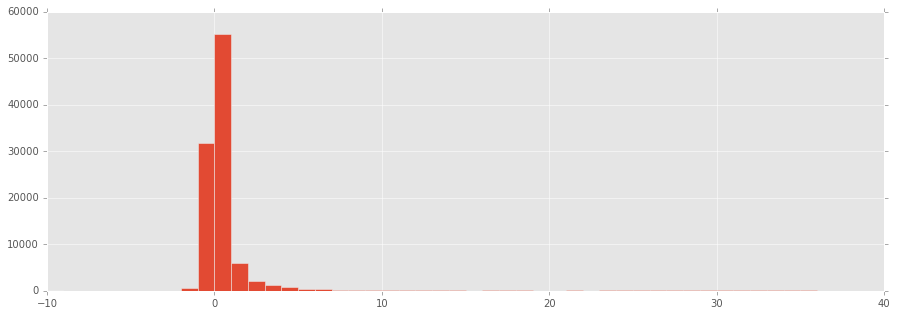

In [13]:
print(DF_joint['movement'].value_counts())
DF_joint['movement'].hist(bins=range(-10,40,1))

In [72]:
for (index, row) in DF_joint.iterrows():
    for y in vt_opinions(json.loads(row['verdicts_x'])):
        if y[0] in vendors:
            DF_joint.loc[index, y[0]] = 1

In [73]:
DF_joint

sha256              time_x  \
0     83486695a2dc925c94f6cb365a8be5ec05904ebeb7ab63... 2016-07-19 09:00:00   
1     0c398616d372cf930502b33c952277caf4a67e2465c06a... 2016-07-19 09:00:01   
2     5091386e988960af685e8cc285c11acd9a2a6ca19006cf... 2016-07-19 09:00:03   
3     92f07d30d3244b4a8053877755b07cbcb7cf5b8ada75bd... 2016-07-19 09:00:09   
4     a749a05b567c92eb6edfc05b11dd2c42f46150e49caff3... 2016-07-19 09:00:10   
5     85fcbc610302b45db278ce92c0e092173c132780d4fa47... 2016-07-19 09:00:14   
6     40fac3634da9a1603605dacc4f65da39f9b886f31f6e46... 2016-07-19 09:00:18   
7     6eb37a8c30cbd5106d13e325737497ec4a064ea4e751e2... 2016-07-19 09:00:23   
8     6dac346079804124491b75036ec65123359766faece438... 2016-07-19 09:00:24   
9     932ec10875bfa2173b332a72ba13149a3a662841662894... 2016-07-19 09:00:26   
10    6caf506a8133c518e1f5b17621712ee82a09ee909f4bce... 2016-07-19 09:00:28   
11    c27a42f1f141fcc872b48781367c2e919dbd4929c860ac... 2016-07-19 09:00:30   
12    a7b286971bd1b0fd67634ec0489ba976c6d2ad8997a801... 2016-07-19 09:00:32   
13    41a00bc02f1d44af402b8982910b8432fbb626a40dfe04... 2016-07-19 09:00:36   
14    1505cd88d7d752a859638344fe0841d7cc885faf928598... 2016-07-19 09:00:36   
15    b666e2abeb45a62fc3f068750f38d5da6773897e3d3e76... 2016-07-19 09:00:37   
16    9b0e39f7d584a5a7bc6f07de76c23f41e4f166837df98e... 2016-07-19 09:00:37   
17    a0ce1cc2b03363786cf4356cf72725a5d30c2b6ad03be3... 2016-07-19 09:00:38   
18    5ebd5e2da565dc8b00bef4e3fc2e30500546ed925d3fe6... 2016-07-19 09:00:38   
19    8900b773ee39ab70f683bc9863023f0993d85203c88c7f... 2016-07-19 09:00:39   
20    8e5140c44b884fa891c7ed03c04c798d8cf0e1cae5fa90... 2016-07-19 09:00:41   
21    69f698eeaf44bc5e2a286d29afff4846683469e0f553d0... 2016-07-19 09:00:44   
22    087737b62a6d52e7f652b3e562c2b77787d7b9d0e37249... 2016-07-19 09:00:44   
23    92eeb0fff47fc257f9d076ff7cbc2f5d614ea1bc85d0ca... 2016-07-19 09:00:45   
24    097251c10ba1ebbbc5d26e4ed358a86dbe8864e2eb1003... 2016-07-19 09:00:46   
25    463ba7bd334c1dbea232cf152ba85e9a196fcc3480dcbb... 2016-07-19 09:00:46   
26    50cc9b2ad2c2cda4d0d0827f97e294824e5b45356892a8... 2016-07-19 09:00:46   
27    3a1d2ab55374aefed56d2cbf71dfbfc1aef6724fc3eed0... 2016-07-19 09:00:47   
28    32e01aa6cb89d1ee344d36cb34a51d13368980a7c2e0c3... 2016-07-19 09:00:48   
29    86d6e0be2885c08f30fde7ca231e19475056240450bd83... 2016-07-19 09:00:49   
...                                                 ...                 ...   
1165  bb3f821d91aa11ca9f37c302cad25680cbde0e3afe8ff4... 2016-07-19 10:39:23   
1166  e0b1d3e457b911b249ba42355f846b3ed772f59a675dfc... 2016-07-19 10:39:28   
1167  a41eda9c0977e022a1cf07606b32f1fcbee6dadeca0440... 2016-07-19 10:39:28   
1168  121fb6547fd5811ed8c42e225ac33a776f329a7438383d... 2016-07-19 10:39:33   
1169  7670e0667490c5478bf1786bf90f22c61eaf37fc58d7ec... 2016-07-19 10:40:34   
1170  90f99dfa45fe5840eb455ba445f68ae22097102e47f253... 2016-07-19 11:10:49   
1171  fbd6c61387aa4d84ab593eddc79c8cfe50aa1d4da914d1... 2016-07-19 11:11:06   
1172  44ac22eaddc320e5fd5a9b81e7aa582706ebb305efc783... 2016-07-19 11:11:25   
1173  8d55ba4248dd865dc7b0ece4e89117cb59c9f9c9f5623e... 2016-07-19 11:11:37   
1174  9467e5a93c047486470016d7313b88a6fa81e70f16144b... 2016-07-19 11:11:46   
1175  19419627c2f9ed2a4d9e48633c7c219ca0e2206e207844... 2016-07-19 11:11:48   
1176  ecaf2bc311ef12e76c32a825f6e6ce3ab7d326efd727a7... 2016-07-19 11:11:57   
1177  bae49e4e664716c29396d645da5503002cca3aae7f3492... 2016-07-19 11:11:58   
1178  e1b99b7dd181b8ad266bd6277f5b4b5891d67bea156aec... 2016-07-19 11:12:08   
1179  7767c845818304b60e903595889283fdedda268a69737b... 2016-07-19 11:12:32   
1180  9e3f70dbc7dcc87a31a52fa07bad290f85c6d5e22e12ca... 2016-07-19 11:12:57   
1181  e354ee3d1f0fae65d90aa78e2dedf223f6a46165ece15e... 2016-07-19 11:13:08   
1182  31b4c62a9f5c65a09b5b1bb035ae7770e3ed79a60728a5... 2016-07-19 11:13:20   
1183  2351d634b71a9307f1b8d217f0b6656875360abb46f620... 2016-07-19 11:13:21   
1184  ab42fb9c656dd0

In [76]:
with open('../data/features.json/features.json') as f:
    TG_vals = json.load(f)

In [83]:
for v in TG_vals.keys():
    print(TG_vals[v])
    break

['pe-uses-dot-net', 'pe-header-linker-major']


In [84]:
TG_labels = pd.read_csv('../data/Jan_CSV/TG_ioc_map.csv')

In [117]:
TG_feats = pd.DataFrame(DF_joint['sha256'])
for i in TG_labels['index']:
    TG_feats[str(i)] = 0

In [118]:
for sha in TG_vals.keys():
    # Step 1: Get the SHA index
    #print(sha)
    sha_ind = TG_feats[TG_feats['sha256'] == sha].index
    #print(sha_ind)
    #print(TG_vals[sha])
    if TG_vals[sha] == None: continue
    for feat in TG_vals[sha]:
        # Step 2: Lookup the feature index
        feat_ind = TG_labels[TG_labels['name'] == feat].index
        if len(feat_ind) == 0: continue
        # Step 3: Set the relevant feature to 1
        TG_feats.loc[sha_ind, str(feat_ind[0])] = 1
        #print(feat_ind[0])
        #break
    #break

In [123]:
TG_feats.iloc[:,1:].values.sum(axis=1)

array([0, 0, 0, ..., 0, 8, 5], dtype=int64)

In [124]:
DF_joint.columns

Index(['sha256', 'time_x', 'verdicts_x', 'positives_x', 'time_y', 'verdicts_y',
       'positives_y', 'lapse', 'movement', 'label', 'microsoft', 'sophos',
       'ikarus', 'bitdefender', 'avast', 'mcafee', 'gdata', 'avg', 'kaspersky',
       'symantec', 'clamav', 'panda', 'drweb', 'trendmicro', 'fortinet',
       'vba32'],
      dtype='object')

In [3]:
import requests

def TG(sha256):
    r = requests.get("https://panacea.threatgrid.com/api/v2/search/submissions",params={"q":sha256,"api_key":"25i6i00k0k91v3llsefesi5u6o"})
    x = r.json()
    print(x)
    if  'data' not in x: 
        return
    items =x['data']['items']
    if items:
        for item in items:
            if 'analysis' in item['item']:
                return item['item']
        return items[0]